In [ ]:
import yfinance as yahooFinance
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from scipy.stats import norm, t, gennorm
import statsmodels.api as sm
%matplotlib inline

In [ ]:
start = "2007-07-01"
end = '2023-11-30'

In [ ]:
WTI = yahooFinance.download('CL=F', start=start, end=end)['Adj Close']
BRENT = yahooFinance.download('BZ=F', start=start, end=end)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


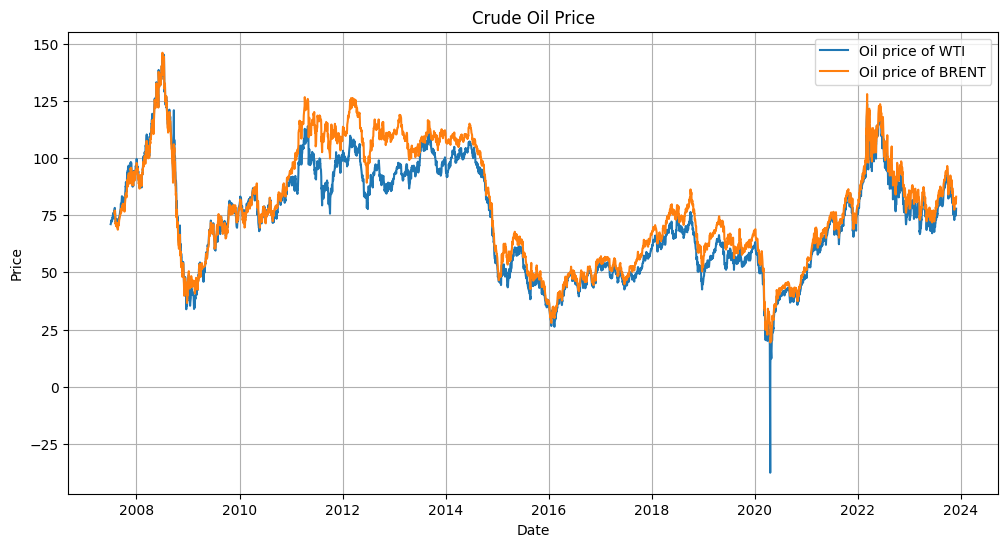

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(WTI, label='Oil price of WTI')
plt.plot(BRENT, label='Oil price of BRENT')
plt.title('Crude Oil Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
WTI = WTI[WTI >= 0]
BRENT = BRENT[BRENT >= 0]

In [ ]:
WTI_returns = WTI.pct_change().dropna()
BRENT_returns = BRENT.pct_change().dropna()

In [ ]:
excel_file_path = 'stock_data.xlsx'
data.to_excel(excel_file_path, sheet_name='StockData', index=True)

In [ ]:
WTI_split_index = int(len(WTI_returns) * 0.75)
WTI_estimation_set = WTI_returns[:WTI_split_index]
WTI_forecast_set = WTI_returns[WTI_split_index:]

BRENT_split_index = int(len(BRENT_returns) * 0.75)
BRENT_estimation_set = BRENT_returns[:BRENT_split_index]
BRENT_forecast_set = BRENT_returns[BRENT_split_index:]

In [ ]:
print(WTI_estimation_set.tail(3))

Date
2019-10-18   -0.002781
2019-10-21   -0.008739
2019-10-22    0.015944
Name: Adj Close, dtype: float64


In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
model_WTI_est = arch_model(WTI_estimation_set, vol='GARCH', p=1, o=1, q=1,power=1.0, dist='ged')


In [ ]:
result_WTI_est = model_WTI_est.fit(disp='off')   #  , last_obs='2019-10-22')


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


In [ ]:
forecast_volatility = result_WTI_est.conditional_volatility

#  VaR
quantiles = forecast_volatility.iloc[-1] * np.percentile(np.random.normal(size=10000), [1, 99])

#  VaR based on GARCH model
value_at_risk = np.sqrt(result_WTI_est.conditional_volatility.iloc[-1]) * quantiles

print("Value at Risk (VaR) based on GARCH model:")
print(value_at_risk)

Value at Risk (VaR) based on GARCH model:
[-0.02853288  0.02969807]


In [ ]:
var_estimates = []

for i in range(len(forecast_volatility)):
    quantiles = forecast_volatility.iloc[i] * np.percentile(np.random.normal(size=10000), [1, 99])
    var_estimate = np.sqrt(result_WTI_est.conditional_volatility.iloc[i]) * quantiles
    var_estimates.append(var_estimate)

var_series = pd.Series(var_estimates, index=forecast_volatility.index)

print("Value at Risk (VaR) series based on GARCH model:")
print(var_series)

Value at Risk (VaR) series based on GARCH model:
Date
2007-07-03     [-0.0027121634483953396, 0.002649633268937983]
2007-07-05    [-0.0033536417621600097, 0.0034255248426078894]
2007-07-06      [-0.004036281237065535, 0.004070697366745127]
2007-07-09      [-0.004671393708120249, 0.004667345815158826]
2007-07-10     [-0.0056318942155677764, 0.005743599522426413]
                                   ...                       
2019-10-16       [-0.030123697978281398, 0.03020133525000722]
2019-10-17       [-0.02897333445066499, 0.029583825742499372]
2019-10-18        [-0.02915758944604898, 0.02930208351431174]
2019-10-21       [-0.02936913331899578, 0.028171945468579197]
2019-10-22       [-0.029242740076112196, 0.02945274201892759]
Length: 3097, dtype: object


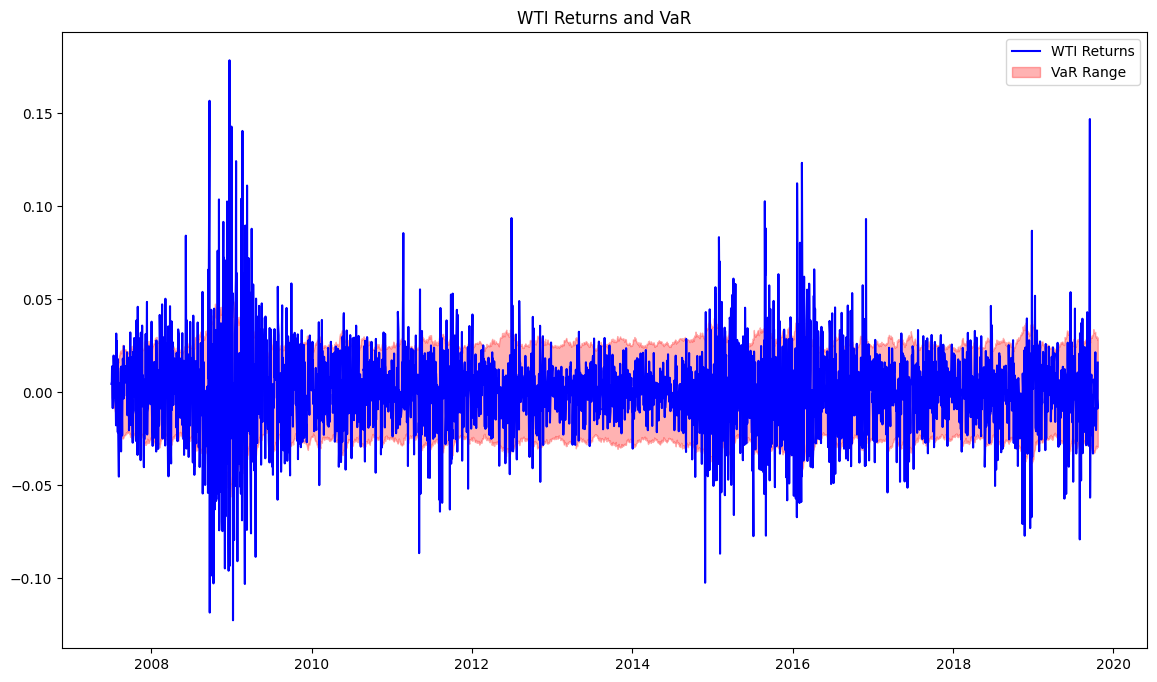

In [ ]:
lower_bounds = [item[0] for item in var_series]
upper_bounds = [item[1] for item in var_series]

plt.figure(figsize=(14, 8))
plt.plot(WTI_estimation_set, label='WTI Returns', color="blue")
plt.fill_between(var_series.index, lower_bounds, upper_bounds, color='red', alpha=0.3, label='VaR Range')
plt.title('WTI Returns and VaR')
plt.legend()
plt.show()

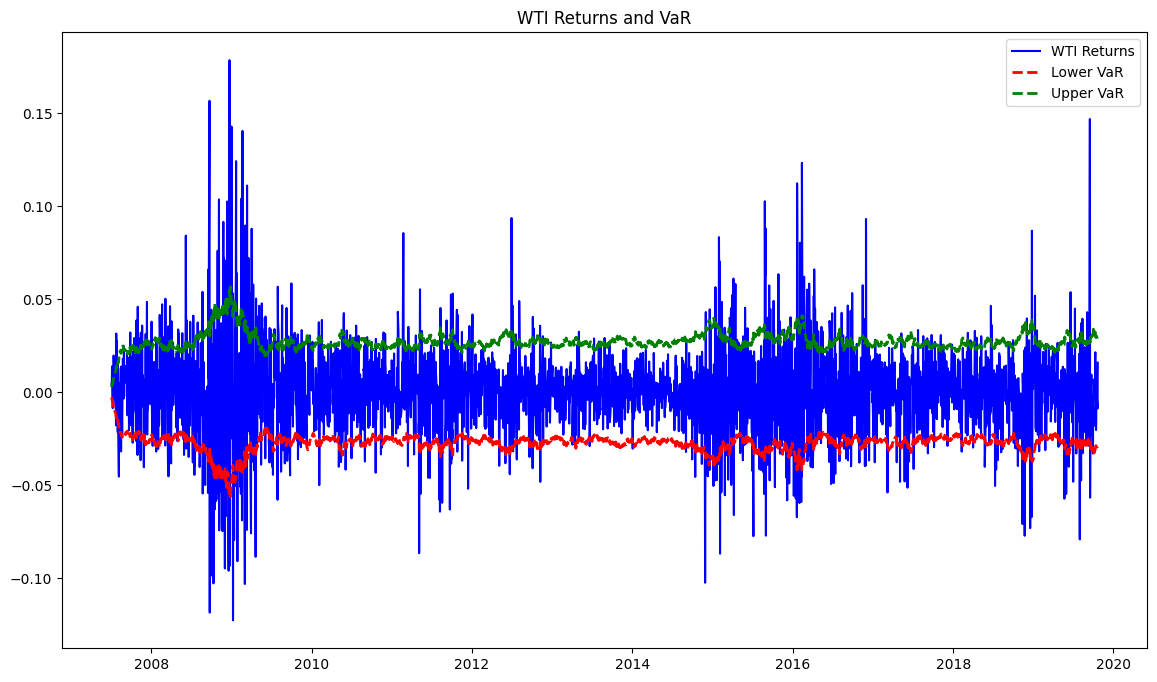

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(WTI_estimation_set, label='WTI Returns', color="blue")
plt.plot(var_series.index, lower_bounds, label='Lower VaR', color='red', linestyle='--', linewidth=2)
plt.plot(var_series.index, upper_bounds, label='Upper VaR', color='green', linestyle='--', linewidth=2)
plt.title('WTI Returns and VaR')
plt.legend()
plt.show()

Adding mean(returns) to VaR equation  ---

In [ ]:
mean_value = result_WTI_est.params['mu']
print(mean_value)

0.037967306219303526


In [ ]:
forecast_volatility = result_WTI_est.conditional_volatility


mean_value = result_WTI_est.params['mu']

lower_var_estimates = []
upper_var_estimates = []

for i in range(len(forecast_volatility)):
    quantiles = np.percentile(np.random.normal(size=10000), [1, 99])

    lower_var_estimate = -mean_value + np.sqrt(result_WTI_est.conditional_volatility.iloc[i]) * quantiles[0]
    lower_var_estimates.append(lower_var_estimate)

    upper_var_estimate = mean_value + np.sqrt(result_WTI_est.conditional_volatility.iloc[i]) * quantiles[1]
    upper_var_estimates.append(upper_var_estimate)

lower_var_series = pd.Series(lower_var_estimates, index=forecast_volatility.index, name='Lower VaR')
upper_var_series = pd.Series(upper_var_estimates, index=forecast_volatility.index, name='Upper VaR')



In [ ]:
print("Lower VaR series based on GARCH model:")
print(lower_var_series)

print("\nUpper VaR series based on GARCH model:")
print(upper_var_series)


Lower VaR series based on GARCH model:
Date
2007-07-03   -0.279842
2007-07-05   -0.301687
2007-07-06   -0.319954
2007-07-09   -0.336085
2007-07-10   -0.355051
                ...   
2019-10-16   -0.582173
2019-10-17   -0.580614
2019-10-18   -0.577389
2019-10-21   -0.573046
2019-10-22   -0.557594
Name: Lower VaR, Length: 3097, dtype: float64

Upper VaR series based on GARCH model:
Date
2007-07-03    0.284606
2007-07-05    0.296726
2007-07-06    0.315323
2007-07-09    0.330961
2007-07-10    0.351998
                ...   
2019-10-16    0.578616
2019-10-17    0.580160
2019-10-18    0.578086
2019-10-21    0.575918
2019-10-22    0.590498
Name: Upper VaR, Length: 3097, dtype: float64


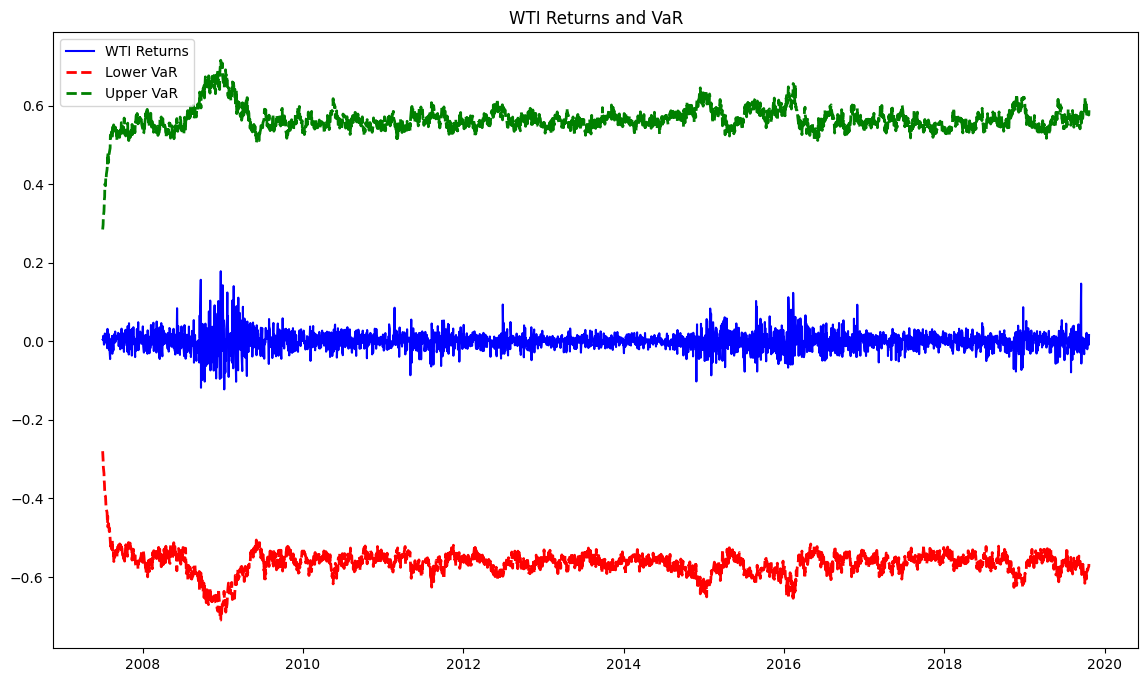

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(WTI_estimation_set, label='WTI Returns', color="blue")
plt.plot(lower_var_series.index, lower_var_series, label='Lower VaR', color='red', linestyle='--', linewidth=2)
plt.plot(upper_var_series.index, upper_var_series, label='Upper VaR', color='green', linestyle='--', linewidth=2)
plt.title('WTI Returns and VaR')
plt.legend()
plt.show()

GED distrib into VaR

In [ ]:
from scipy.stats import genextreme

In [ ]:
forecast_volatility = result_WTI_est.conditional_volatility

mean_value = result_WTI_est.params['mu']
lower_var_estimates = []
upper_var_estimates = []

In [ ]:
for i in range(len(forecast_volatility)):
    # GED distributed random samples
    ged_samples = genextreme.rvs(c=1, size=10000)

    # Calculate quantiles for GED distribution
    quantiles = np.percentile(ged_samples, [1, 99])

    # Lower VaR estim
    lower_var_estimate =  np.sqrt(result_WTI_est.conditional_volatility.iloc[i]) * quantiles[0]
    lower_var_estimates.append(lower_var_estimate)

    # Upper VaR estim
    upper_var_estimate =  np.sqrt(result_WTI_est.conditional_volatility.iloc[i]) * quantiles[1]
    upper_var_estimates.append(upper_var_estimate)

lower_var_series = pd.Series(lower_var_estimates, index=forecast_volatility.index, name='Lower VaR')
upper_var_series = pd.Series(upper_var_estimates, index=forecast_volatility.index, name='Upper VaR')

In [ ]:
print("Lower VaR series based on GARCH model and GED distribution:")
print(lower_var_series)

print("\nUpper VaR series based on GARCH model and GED distribution:")
print(upper_var_series)

Lower VaR series based on GARCH model and GED distribution:
Date
2007-07-03   -0.388457
2007-07-05   -0.428015
2007-07-06   -0.444165
2007-07-09   -0.444619
2007-07-10   -0.484171
                ...   
2019-10-16   -0.832472
2019-10-17   -0.856190
2019-10-18   -0.829060
2019-10-21   -0.855736
2019-10-22   -0.842722
Name: Lower VaR, Length: 3097, dtype: float64

Upper VaR series based on GARCH model and GED distribution:
Date
2007-07-03    0.103603
2007-07-05    0.112243
2007-07-06    0.119692
2007-07-09    0.124541
2007-07-10    0.133710
                ...   
2019-10-16    0.232595
2019-10-17    0.230974
2019-10-18    0.229473
2019-10-21    0.229256
2019-10-22    0.229903
Name: Upper VaR, Length: 3097, dtype: float64


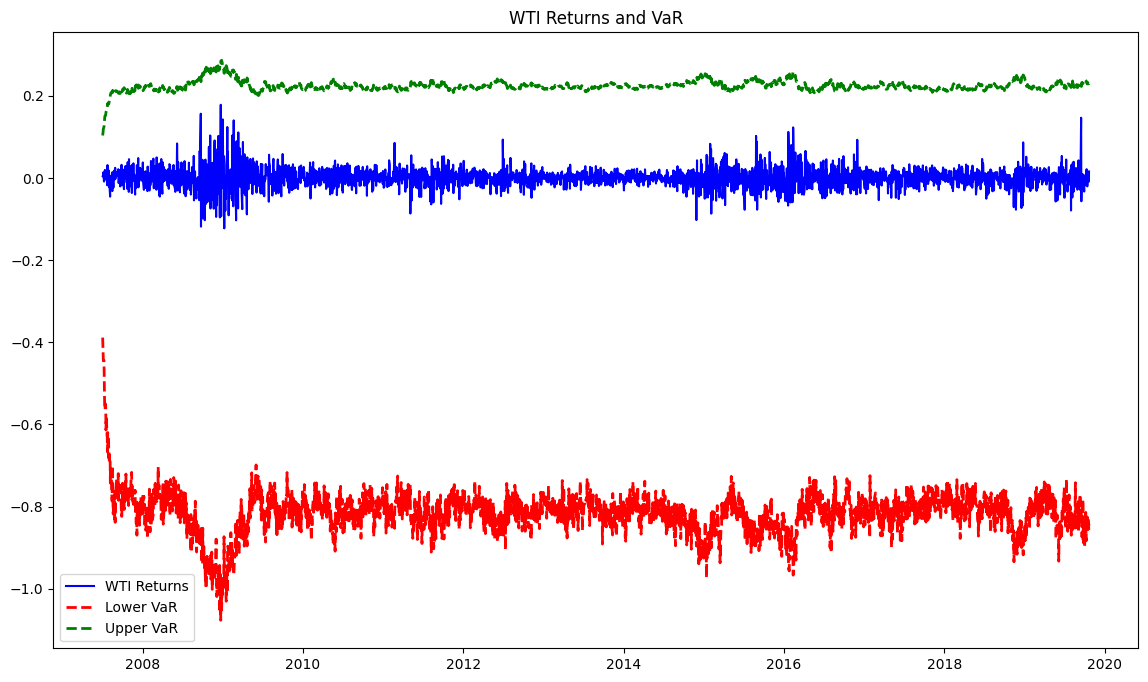

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(WTI_estimation_set, label='WTI Returns', color="blue")
plt.plot(lower_var_series.index, lower_var_series, label='Lower VaR', color='red', linestyle='--', linewidth=2)
plt.plot(upper_var_series.index, upper_var_series, label='Upper VaR', color='green', linestyle='--', linewidth=2)
plt.title('WTI Returns and VaR')
plt.legend()
plt.show()

In [ ]:
forecast_volatility = result_WTI_est.conditional_volatility

var_estimates = []

for i in range(len(forecast_volatility)):

    ged_samples = genextreme.rvs(c= 1.5, size=1000)  #c is the sharp param

    quantiles = np.percentile(ged_samples, [1, 99])

    var_estimate = np.sqrt(result_WTI_est.conditional_volatility.iloc[i]) * quantiles
    var_estimates.append(var_estimate)

var_series = pd.Series(var_estimates, index=forecast_volatility.index)

print("Value at Risk (VaR) series based on GARCH model and GED distribution:")
print(var_series)

Value at Risk (VaR) series based on GARCH model and GED distribution:
Date
2007-07-03     [-0.5576857526405088, 0.0696788626612781]
2007-07-05    [-0.6805527959198767, 0.07557888387452764]
2007-07-06    [-0.6439265415851236, 0.08056907707460281]
2007-07-09    [-0.9368326131359724, 0.08374321404319338]
2007-07-10    [-0.8205121358141534, 0.08999809593811774]
                                 ...                    
2019-10-16    [-1.2036577864223965, 0.15669580829094987]
2019-10-17    [-1.4879988973703067, 0.15544798374772725]
2019-10-18    [-1.3970519072189826, 0.15423129333856125]
2019-10-21    [-1.2258938795776255, 0.15419154156689624]
2019-10-22      [-1.29564060923945, 0.15465969216308034]
Length: 3097, dtype: object


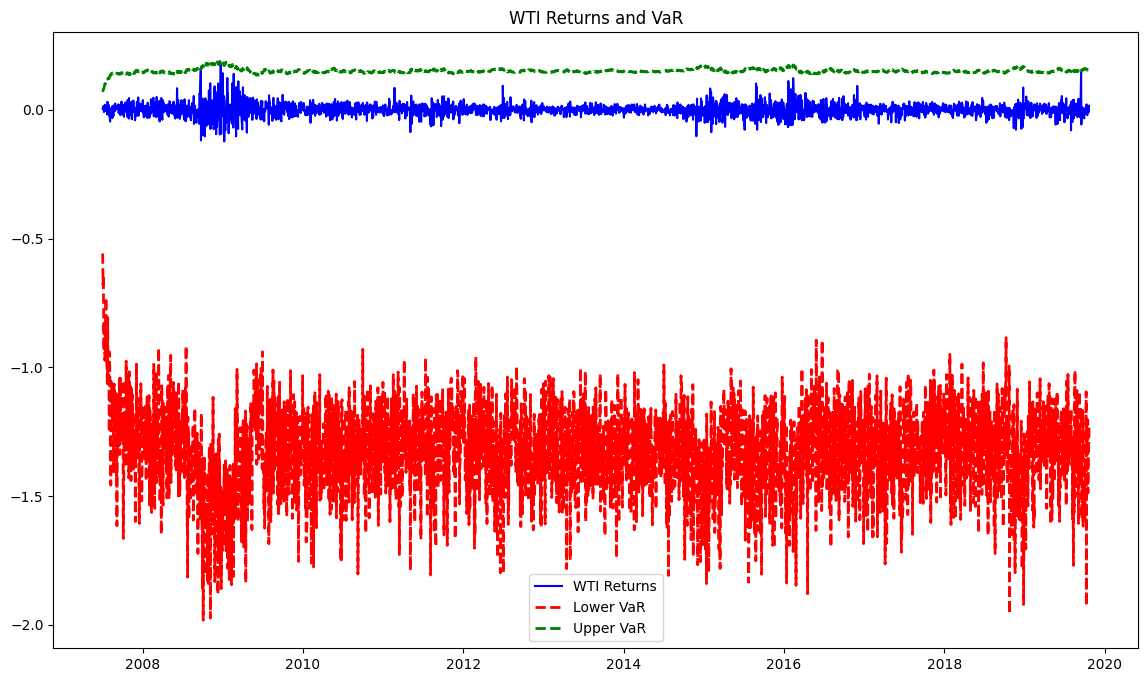

In [ ]:
lower_bounds = [item[0] for item in var_series]
upper_bounds = [item[1] for item in var_series]


plt.figure(figsize=(14, 8))
plt.plot(WTI_estimation_set, label='WTI Returns', color="blue")
plt.plot(var_series.index, lower_bounds, label='Lower VaR', color='red', linestyle='--', linewidth=2)
plt.plot(var_series.index, upper_bounds, label='Upper VaR', color='green', linestyle='--', linewidth=2)
plt.title('WTI Returns and VaR')
plt.legend()
plt.show()

In [ ]:
print(result_WTI_est.params[-1:])

nu    1.512907
Name: params, dtype: float64


In [ ]:
forecasts = result_WTI_est.forecast(start="2019-10-23", reindex=False)
cond_mean = forecasts.mean["2019":]
cond_var = forecasts.variance["2019":]
q = model_WTI_est.distribution.ppf([0.01, 0.05], result_WTI_est.params[-1:])
print(q)


[-2.49260788 -1.65272268]
